# Load libraries and data

### Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words("english")

from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [22]:
# Model using SVM

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

### NLP Dataset

In [5]:
df_a = pd.read_csv(r'val.txt', sep = ";")
df_a.columns = ['text', 'sentiment']
df_b = pd.read_csv(r'train.txt', sep = ";")
df_b.columns = ['text', 'sentiment']
df_c = pd.read_csv(r'test.txt', sep = ";")
df_c.columns = ['text', 'sentiment']
df = pd.concat([df_a, df_b, df_c], ignore_index=True)
print(df.shape)
df.head()

(19997, 2)


,text,sentiment
0,i feel like i am still looking at a blank canv...,sadness
1,i feel like a faithful servant,love
2,i am just feeling cranky and blue,anger
3,i can have for a treat or if i am feeling festive,joy
4,i start to feel more appreciative of what god ...,joy


#### Abbreviations

In [6]:
def convert_abbrev(word):
    return abbreviations[word] if word.lower() in abbreviations.keys() else word

#list of abbreviations from https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/notebook
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bf" : "boyfriend",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}


#### Balance classes

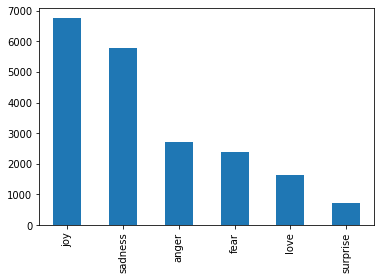

In [7]:
v_count = df['sentiment'].value_counts()
v_count.plot(kind='bar')

# Clean data, tokenization, lemmatization

In [8]:
def flatten(text):
  return [i for j in text for i in j]

In [9]:
def lemm_sentence(sentence):
  sentence = ' '.join(sentence)
  lemmatized_sentence = []
  #tokenize the sentence
  tokens = word_tokenize(sentence)
  #tag the POS of each token
  pos_tags = pos_tag(tokens)
  #iterate through each token and its POS tag
  for token, pos in pos_tags:
      #map the POS tag to the first character used by the WordNetLemmatizer
      pos = {
          'N': 'n',
          'V': 'v',
          'R': 'r',
          'J': 'a'
      }.get(pos[0], 'n')
      lemmatized_sentence.append(lemmatizer.lemmatize(token, pos=pos))
  return lemmatized_sentence

In [10]:
neg_list = ["not","never","n't"]

In [11]:
def neg_verbs(text):
  c = 0
  newtext = []
  for w in text.split():
    if c == 1:
      c == 0
      for syn in wordnet.synsets(w):
        for lm in syn.lemmas()[:1]:
          if lm.antonyms():
            w = lm.antonyms()[0].name()
          break
    else:
      if w.endswith(tuple(neg_list)):
        c = 1
    newtext.append(w)
  return newtext

In [12]:
def cleaner(text):

  text = text.lower()

  #remove @nickname, hashtags, links, punctuation  
  text = re.sub("(@[A-Za-z0-9]+)","",text)
  text = re.sub("#","",text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub('\w+:\/\/\S+', '', text)
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub(r'\d+', ' ', text)

  text = neg_verbs(text)
  text = [convert_abbrev(w) for w in text]
  text = [w.split() for w in text]
  text = flatten(text)
  
  #lemmatization
  text = lemm_sentence(text)
  
  #remove stopwords  
  text = [w for w in text if w not in stop_words]
  return text

In [13]:
df['text'] = [cleaner(tx) for tx in df['text']]

In [14]:
df.head()

,text,sentiment
0,"[feel, like, still, look, blank, canvas, blank...",sadness
1,"[feel, like, faithful, servant]",love
2,"[feel, cranky, blue]",anger
3,"[treat, feel, festive]",joy
4,"[start, feel, appreciative, god]",joy


# Model: splitting the dataset, TF-IDF, SVM

In [15]:
X = df['text']
y = df['sentiment']

In [16]:
X.shape

(19997,)

In [17]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X.astype('U'))

In [18]:
from sklearn.model_selection import train_test_split

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=18000, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18000, 13996), (1997, 13996), (18000,), (1997,))

In [19]:
len_X_train = 20
ind_list = np.zeros(len_X_train)

acc_train_list = []
acc_test_list = []

cv_num = 5
sample_length = len_X_train / cv_num
for i in range(cv_num):

  ind_list = np.zeros(len_X_train)
  init = int(i * sample_length)
  end = int((i+1) * sample_length)
  ind_list[init:end] = 1
  print(ind_list)

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [29]:
#cross validation

len_X_train = X_train.shape[0]
ind_list = np.zeros(len_X_train)

acc_train_list = []
acc_test_list = []

cv_num = 5
sample_length = len_X_train / cv_num
for i in range(cv_num):

  ind_list = np.zeros(len_X_train)
  init = int(i * sample_length)
  end = int((i+1) * sample_length)
  ind_list[init:end] = 1
  
  #subset
  X_train_cv = X_train[ind_list == 0]
  X_test_cv = X_train[ind_list == 1]

  y_train_cv = y_train[ind_list == 0]
  y_test_cv = y_train[ind_list == 1]

  #create the model
  svm = LinearSVC()
  model = CalibratedClassifierCV(svm)
  model.fit(X_train_cv, y_train_cv)

  #get labels
  if i == 0:
    keys = range(20)
    sent = model.classes_
    ind_to_sent = dict(zip(keys, sent))

  y_pred_train = model.predict(X_train_cv)
  y_pred_multi = model.predict_proba(X_test_cv)
  y_pred_test = [np.argmax(y_pt) for y_pt in y_pred_multi]
  y_pred_test = [ ind_to_sent[i] for i in y_pred_test]

  acc_train = accuracy_score(y_train_cv, y_pred_train)
  acc_test = accuracy_score(y_test_cv, y_pred_test)

  acc_train_list.append(acc_train)
  acc_test_list.append(acc_test)
  print(i)
  print(f'Training accuracy: {acc_train}')
  print(f'Test accuracy: {acc_test}')



0
Training accuracy: 0.9743055555555555
Test accuracy: 0.8552777777777778
1
Training accuracy: 0.9725
Test accuracy: 0.8586111111111111
2
Training accuracy: 0.9755555555555555
Test accuracy: 0.8547222222222223
3
Training accuracy: 0.975
Test accuracy: 0.8483333333333334
4
Training accuracy: 0.9746527777777778
Test accuracy: 0.8525


In [25]:
print("Training accuracy: ",round(np.mean(acc_train_list),3),"±",round(np.std(acc_train_list),3))
print("Test accuracy: ",round(np.mean(acc_test_list),3),"±",round(np.std(acc_test_list),3))

Training accuracy:  0.974 ± 0.001
Test accuracy:  0.854 ± 0.003


In [30]:
X_cv_train = X_train
y_cv_train = y_train
svm = LinearSVC()
model = CalibratedClassifierCV(svm)
model.fit(X_cv_train, y_cv_train)

y_pred_train = model.predict(X_train)
y_pred_multi = model.predict_proba(X_test)
y_pred_test = [np.argmax(y_pt) for y_pt in y_pred_multi]
y_pred_test = [ ind_to_sent[i] for i in y_pred_test]

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

acc_train_list.append(acc_train)
acc_test_list.append(acc_test)

print(f'Training accuracy: {acc_train}')
print(f'Test accuracy: {acc_test}')

Training accuracy: 0.9705
Test accuracy: 0.8637956935403105


In [27]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       anger       0.84      0.88      0.86       283
        fear       0.83      0.79      0.81       231
         joy       0.88      0.91      0.89       660
        love       0.74      0.64      0.68       159
     sadness       0.90      0.91      0.90       585
    surprise       0.85      0.81      0.83        79

    accuracy                           0.86      1997
   macro avg       0.84      0.82      0.83      1997
weighted avg       0.86      0.86      0.86      1997



In [28]:
sent = ['anger', 'fear', 'joy','love','sadness','surprise']
sent

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

# Movie Corpus

In [31]:
def title_cleaner(x):
    return re.sub(r"[^\w ]", "", x.lower())

In [32]:
def filter_head(lines): 
  #delete common scene headings 
  patternDel = '(?:INT|EXT|CONTIN|CUT|DISSOLVE|TITLE|FADE|BACK|------------------).[^>]+'
  return lines['Character'].str.contains(patternDel, regex=True)

## Extract lines


In [33]:
def get_lines(x):
 
  #delete notes w/o leaving space
  x = re.sub(r'\([^)]*\)\s?\n', '', x)
  x = re.sub(r'\[[^)]*\]\s?\n', '', x)
  x = re.sub('"', '', x)
  #delete parenthesis (so that voiceovers and other notes do not create 'fake characters')
  x = re.sub(r'\([^)]*\)', '', x)
  x = re.sub(r'\[[^)]*\]', '', x)
  
  #delete tabs
  x = re.sub("\t", '', x)

  #better splitter for some scripts
  spl = x.split('\n')[1::2]
  if spl == [''] * len(spl):
    x = '\n'.join(x.split('\n')[0::2])
  #split paragraphs
  line = re.split(r'^[^a-z\n]*$',x, flags = re.DOTALL | re.MULTILINE)
  line.pop(0)  
  #line = pd.Series([re.sub(r"\s+", ' ', i) for i in line])
  line = pd.Series([re.sub(r"\n", ' ', i) for i in line])
  
  line_auth = re.findall(r'^[^a-z\n]*$', x, flags = re.DOTALL | re.MULTILINE)
  line_auth = pd.Series([re.sub('\n', '', i) for i in line_auth])
  line_auth = pd.Series([re.sub(r'^\s+', '', i) for i in line_auth])

  lines = pd.concat([line_auth,line],axis=1)
  lines.columns = ['Character', 'Line']
  filter = filter_head(lines)

  #delete empty rows
  filter2 = lines['Character'] == '' 
  filter3 = lines['Character'] == ' '

  #potential characters with long names are potential mistakes
  filter4 = lines['Character'].str.len() > 20
  
  lines = lines[~filter & ~filter2 & ~filter3 & ~filter4]

  return lines

In [34]:
def get_lines_2(x):
  #in this case we consider "character : line" (an example is the star wars prequel trilogy)
  #delete parenthesis (so that voiceovers and other notes do not create 'fake characters')
  x = re.sub('\[', '(', x)
  x = re.sub('\]', ')', x)
  x = re.sub(r'\([^)]*\)', '', x)

  #select rows containing ':'
  line = re.split(r'^[^a-z\n]*$',x, flags = re.DOTALL | re.MULTILINE)
  line = pd.Series([re.sub(r"\s+", ' ', i) for i in line])
  
  #delete paragraphs that do not use ":"
  patternDel = ':'
  filter_dots = line.str.contains(patternDel)

  #delete empty rows
  filter2 = line == '' 
  filter3 = line == ' '

  line = line[filter_dots & ~filter2 & ~filter3]
  
  new = line.str.split(pat = ":", n = 1, expand = True)
  if new.empty:
    lines = get_lines_3(x)
  else:
    lines = pd.concat([new[0],new[1]],axis=1)
    lines.columns = ['Character', 'Line']
    filter = filter_head(lines)
  return lines

In [35]:
def get_lines_3(x):
  print("trying third  ", end='')

  new = x.str.split(pat = "\n", n = 1, expand = True)
  
  lines = pd.concat([new[0],new[1]],axis=1)
  lines.columns = ['Character', 'Line']

  lines['Line'] = lines['Line'].str.replace('\n',' ')
  
  filter = filter_head(lines)

  #delete empty rows
  filter2 = lines['Character'] == '' 
  filter3 = lines['Character'] == ' '

  lines = lines[~filter & ~filter2 & ~filter3]


  return lines

In [36]:
#define a minimum number of lines for the protagonist
thr_lines = 20

def get_protagonist_lines(x):
  lines = get_lines(x)

  if lines.empty or lines['Character'].value_counts()[0] < thr_lines:
    lines = get_lines_2(x)

  protagonist = lines['Character'].value_counts().index.tolist()[0]
  protagonist_lines = lines[lines['Character'] == protagonist]['Line']
  
  return protagonist, protagonist_lines

## Open script

In [37]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

'''a method to scrape directly from the web if available -- sometimes offline'''
# Fetch the html file
#html_script = urlopen('https://imsdb.com/scripts/Star-Wars-Revenge-of-the-Sith.html').read()
# Parse the html file
#soup = BeautifulSoup(html_script, 'html.parser')

# Format the parsed html file
#txt_script = soup.prettify()

# Print the first few characters
#init = txt_script.rfind("STAR WARS")
#out = txt_script.rfind("END TITLES.")
#txt_script = txt_script[init:out]
#txt_script = re.sub('<br/>','\n',txt_script)
#txt_script = re.sub('</b>','',txt_script)

base_dir = "Annie Hall_0075686.txt"
txt_script = open(base_dir).read()

print(txt_script[:1200])




					ANNIE HALL

			      written by
		   	      Woody Allen
			   Marshall Brickman

(Sound and Woody Allen monologue begin)

FADE IN:

White credits dissolve in and out on black screen.  No sound.

								FADE OUT: credits

FADE IN:

Abrupt medium close-up of Alvy Singer doing a comedy monologue.  He
wearing a crumbled sports jacket and tieless shirt; the background is stark.

				ALVY         
		There's an old joke.  Uh, two elderly 
		women are at a Catskills mountain 
		resort, and one of 'em says: "Boy, the 
		food at this place is really terrible." 
		The other one says, "Yeah, I know, and 
		such ... small portions." Well, that's 
		essentially how I feel about life.  Full 
		of loneliness and misery and suffering 
		and unhappiness, and it's all over much 
		too quickly.  The-the other important 
		joke for me is one that's, uh, usually 
		attributed to Groucho Marx, but I think 
		it appears originally in Freud's wit and 
		its relation to the unconscious.  And it 
		goes 

In [38]:
protagonist, quotes = get_protagonist_lines(txt_script)

print('The protagonist is ', protagonist)   
print('There are ', len(quotes), ' quotes.' )
quotes.head()

The protagonist is  ALVY 
There are  372  quotes.


27                          The universe is expanding. 
31     Well, the universe is everything, and if  it'...
36                                   What's the point? 
88                                        What'd I do? 
92                                        What'd I do? 
Name: Line, dtype: object

In [39]:
quotes = pd.Series([cleaner(tx) for tx in quotes])

quotes2 = vectorizer.transform(quotes.astype('U'))
y_pred_multi = model.predict_proba(quotes2)

y_pred_test = [np.argmax(y_pt) for y_pt in y_pred_multi]
y_pred_test = [ind_to_sent[i] for i in y_pred_test]


In [40]:
df_final_emot = pd.DataFrame(y_pred_multi)
df_final_emot.columns = ['anger', 'fear','joy', 'love', 'sadness', 'surprise']
df_final_emot.shape

(372, 6)

In [41]:
df_final_emot.to_csv("/content/emotion.csv", sep = "$")

In [42]:
sent_col = ['red', 'navy', 'green', 'maroon', 'blue', 'grey']

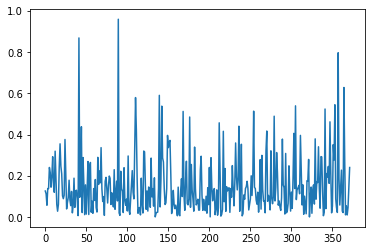

In [43]:
emotion = [i[0] for i in y_pred_multi]

plt.plot(emotion)

In [44]:
def rollavg(data,n):
    d = pd.Series(data)
    return d.rolling(n).mean()

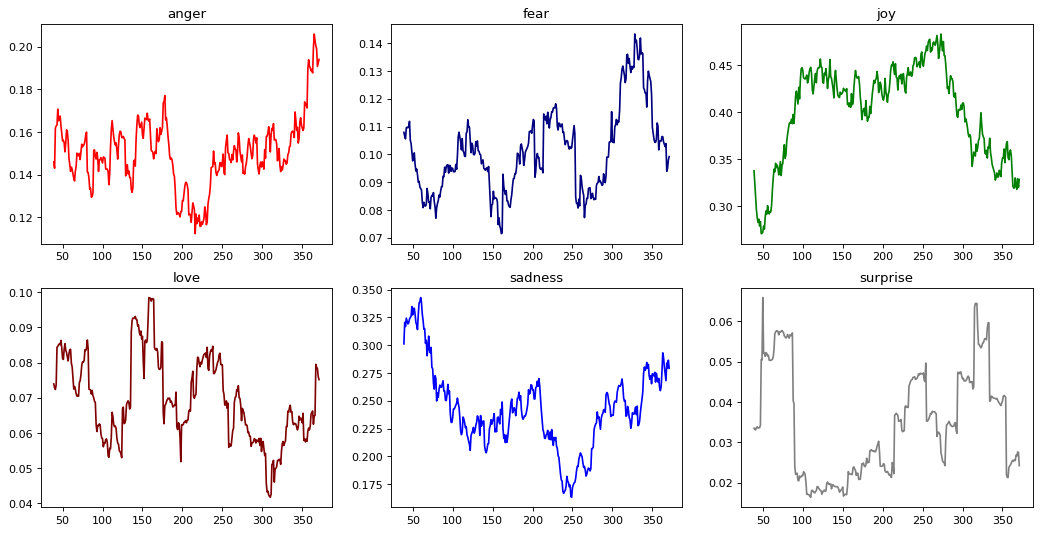

In [45]:
import matplotlib
matplotlib.use('Agg')
from matplotlib.pyplot import figure

figure(figsize=(16, 8), dpi=80)

for j in range(len(y_pred_multi[0])):
  emotion = [i[j] for i in y_pred_multi]
  emotion_av = rollavg(emotion,40)
  
  plt.subplot(2, 3, j+1)
  plt.plot(emotion_av, color=sent_col[j])
  plt.title(sent[j])
plt.show()

#Movie Corpus Complete
This section is useful only if one is interested in scraping the whole dataset

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')'''

In [ ]:
'''def check_special(x):
  x = re.sub('\.','',x)
  x = re.sub('\-','',x)
  return bool(re.search(r'[^a-zA-Z\d\s:]',x))'''

In [ ]:
'''base_dir = "/content/drive/MyDrive/movie_corpus/raw_texts"

i = 1
ncol = 2
protagonists_list = []
df_lines = pd.DataFrame(np.zeros([1000, ncol])*np.nan)
iii = 0
for script_name in os.listdir(base_dir):
  # open the script
  with (open(base_dir + "/" + script_name, "r", errors="ignore")) as script_file:

    movie_name = title_cleaner("_".join(script_name.split("_")[:-1]))
    protagonist, lines = get_protagonist_lines(script_file.read())

    #lines into lexicon
    ###
    ###
    
    if len(protagonist) < 20 and len(lines) > thr_lines and not check_special(protagonist):
      #print(i, end='')
      #i += 1
      #print ("  -  ", end='')
      print(movie_name)#, end='')
      #print ("  -  ", end='')
      #print(protagonist)   
      protagonists_list.append(protagonist)
      lines_list.append(lines)
      iii +=1
    if iii == ncol:
      break
protagonists_list'''